# Anna_Smetanina_727358 -  team's leaderboard

In [1]:
import os
from google.colab import drive
import torch
import datetime
import numpy as np

In [61]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [2]:
# Папка, куда будем сохранять модели
SAVE_DIR = "/content/drive/MyDrive/Deep Learning school MIPT part 1"

# Проверяем, смонтирован ли Drive
if not os.path.exists("/content/drive/MyDrive"):
    print("Mounting Google Drive...")
    drive.mount("/content/drive")

# Проверяем, существует ли нужная папка
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR, exist_ok=True)
    print(f"Created folder: {SAVE_DIR}")
else:
    print(f"Save folder already exists: {SAVE_DIR}")


Mounting Google Drive...
Mounted at /content/drive
Save folder already exists: /content/drive/MyDrive/Deep Learning school MIPT part 1


In [4]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [5]:
!nvidia-smi

Mon Nov 17 10:34:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from torchvision.transforms import v2

import torchsummary

from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [7]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']

# работаем на видеокарте
DEVICE = torch.device("cuda")

#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('/content/train') #Path('./data/train/')
TEST_DIR = Path('/content/testset') #Path('./data/testset')

# параметры нормировки изображений по трем каналам перед подачей в модель
NORMALIZE_MEAN = [0.485, 0.456, 0.406]
NORMALIZE_STD = [0.229, 0.224, 0.225]

# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = [224, 224]

In [8]:
!mkdir -p /content
!unzip -q -o "/content/drive/MyDrive/Deep Learning school MIPT part 1/journey-springfield.zip" -d /content

In [9]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [10]:
label_encoder = LabelEncoder()

train_val_labels = [path.parent.name for path in train_val_files]

label_encoder.fit(train_val_labels)

LabelEncoder()

In [11]:
from sklearn.model_selection import train_test_split

train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

Применим аугментацию данных к тренировочному набору

In [12]:
class SimpsonsDataset(Dataset):
    def __init__(self, files, label_encoder, mode):
        super().__init__()

        self.files = sorted(files)

        self.mode = mode
        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.label_encoder = label_encoder
        self.len_ = len(self.files)

    def __len__(self):
        return self.len_ # сейчас self.__len__() возвращает количество картинок, подаваемых на вход.
        # Если вы решите перевзвесить размеры категорий внутри класса -
        # не забудьте изменить вывод self.__len__()

    def __getitem__(self, index):
        x = self.load_image(self.files[index])
        x = self.transform_images_to_tensors(x)

        if self.mode == 'test':
            return x
        else:
            path = self.files[index]
            y = self.label_encoder.transform([path.parent.name,]).item()
            return x, y


    def load_image(self, file):
        image = Image.open(file)
        image.load()
        return image



    def transform_images_to_tensors(self, image):
      if self.mode == 'train':
          transform = v2.Compose([
              v2.Resize(RESCALE_SIZE),

              v2.RandomResizedCrop(RESCALE_SIZE, scale=(0.8, 1.0)),
              v2.RandomHorizontalFlip(p=0.5),
              v2.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.02),
              v2.GaussianBlur(kernel_size=3, sigma=(0.1, 1.5)),

              v2.PILToTensor(),
              v2.ToDtype(torch.float32, scale=True),
              v2.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
          ])

      else:
          transform = v2.Compose([
              v2.Resize(RESCALE_SIZE),
              v2.PILToTensor(),
              v2.ToDtype(torch.float32, scale=True),
              v2.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
          ])

      tensor_transformed = transform(image)
      return tensor_transformed



In [13]:
train_dataset = SimpsonsDataset(train_files, label_encoder = label_encoder, mode='train')
val_dataset = SimpsonsDataset(val_files, label_encoder, mode='val')

In [27]:
batch_size = 128

Добавим WeightedRandomSampler, потому что есть классы очень редко встречабщиеся - их будем чаще добавлять в батчи трейна. Вместо шаффла.

In [63]:
from collections import Counter
from torch.utils.data import WeightedRandomSampler

train_labels = [label_encoder.transform([p.parent.name])[0] for p in train_files]
class_counts = Counter(train_labels)

print("Дисбаланс по классам:")
for cls_id, count in class_counts.items():
    print(f"{label_encoder.inverse_transform([cls_id])[0]} {count}")

num_samples = len(train_labels)
class_weights = {cls: num_samples / count for cls, count in class_counts.items()}
sample_weights = torch.DoubleTensor([class_weights[lbl] for lbl in train_labels])

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

Дисбаланс по классам:
charles_montgomery_burns 895
milhouse_van_houten 809
comic_book_guy 352
lenny_leonard 233
bart_simpson 1006
lisa_simpson 1015
edna_krabappel 343
homer_simpson 1684
mayor_quimby 185
ned_flanders 1090
krusty_the_clown 904
moe_szyslak 1089
apu_nahasapeemapetilon 467
selma_bouvier 77
chief_wiggum 739
waylon_smithers 136
principal_skinner 895
abraham_grampa_simpson 685
sideshow_bob 658
kent_brockman 373
martin_prince 53
carl_carlson 74
barney_gumble 80
marge_simpson 968
patty_bouvier 54
professor_john_frink 49
agnes_skinner 32
otto_mann 24
snake_jailbird 41
cletus_spuckler 35
nelson_muntz 269
fat_tony 20
groundskeeper_willie 91
ralph_wiggum 67
maggie_simpson 96
rainier_wolfcastle 34
gil 20
miss_hoover 13
sideshow_mel 30
troy_mcclure 6
disco_stu 6
lionel_hutz 2


In [64]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=sampler,
    num_workers=0,
    pin_memory=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)


In [65]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False

In [66]:
loaders = {'train':train_loader, 'val': val_loader}

In [18]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

Числовая метка класса: 28
Текстовая метка класса: ['ned_flanders']


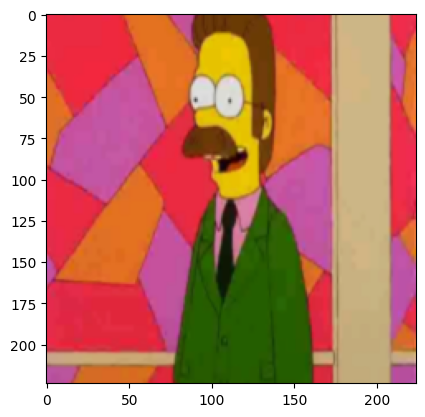

In [21]:
image_tensor, label = next(iter(train_loader))
print(f"Числовая метка класса: {label[0]}")
print(f"Текстовая метка класса: {label_encoder.inverse_transform([label[0],])}")
imshow(image_tensor[0])


In [22]:
def show_images(n_rows, n_cols, dataset):
  # функция выводит изображения в n_rows рядов и n_cols столбцов
  fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 4, n_rows * 4), \
                        sharey=True, sharex=True)

  for fig_x in ax.flatten(): # цикл повторяется (n_rows * n_cols) раз
    random_characters = int(np.random.uniform(0, len(dataset))) # берем случайное число в диапазоне [0; len(dataset))
    im_val, label = dataset[random_characters] # получаем изображение (тензорная форма)
    img_label = " ".join(map(lambda x: x.capitalize(), \
                             label_encoder.inverse_transform([label])[0].split('_')))  # числовую метку класса преобразуем в текстовую и немного отформатируем
    imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x) # отобразим изображение и метку класса с помощью написанной ранее функции imshow()
    fig_x.set_axis_off()
  return None

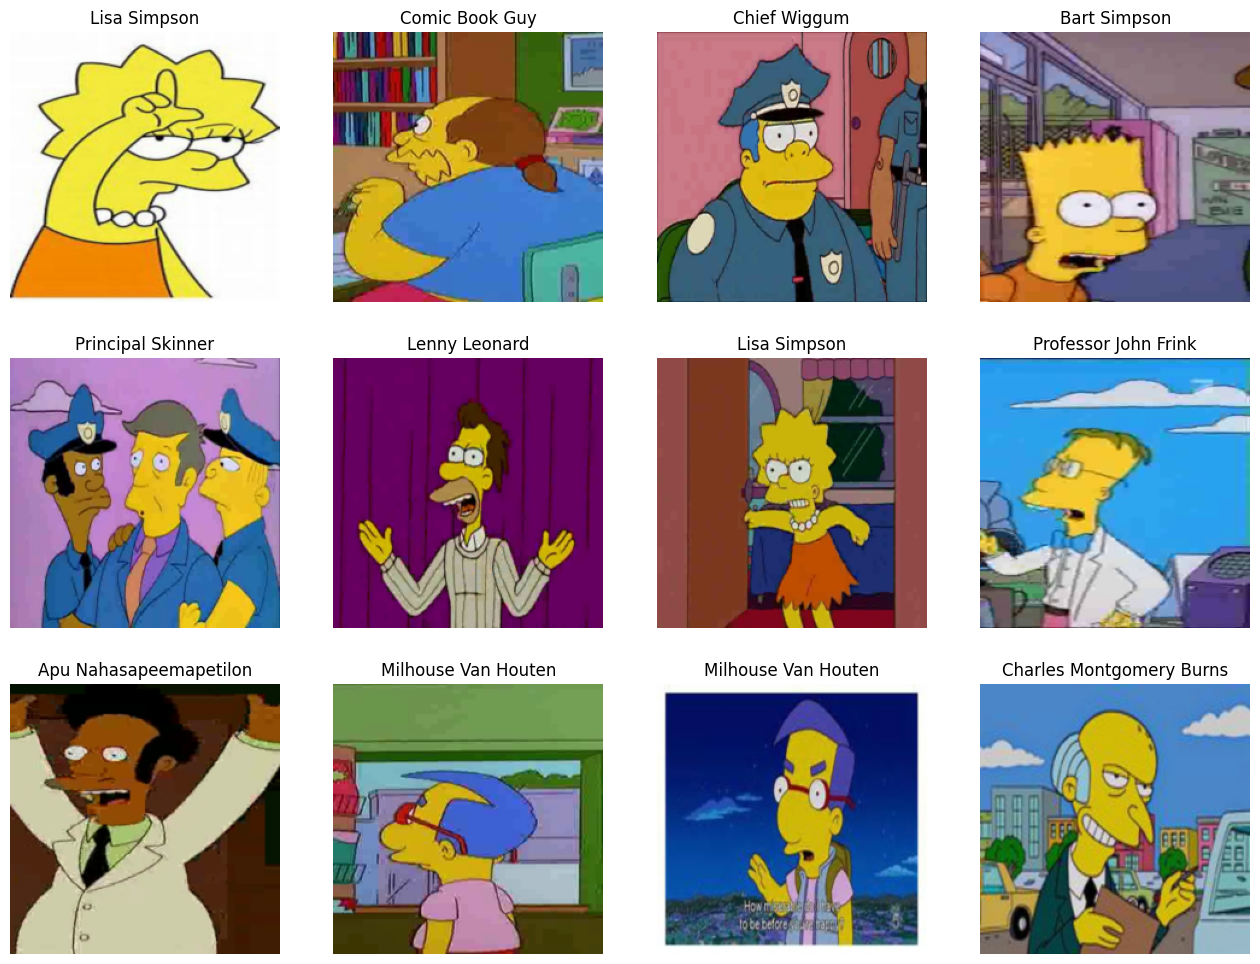

In [23]:
show_images(n_rows = 3, n_cols = 4, dataset = val_dataset)

Посмотрим как выглядит аугментация данных для трейна. более размытый, чем валидационный, то есть, учиться будет сложнее, а распознавать зато легче

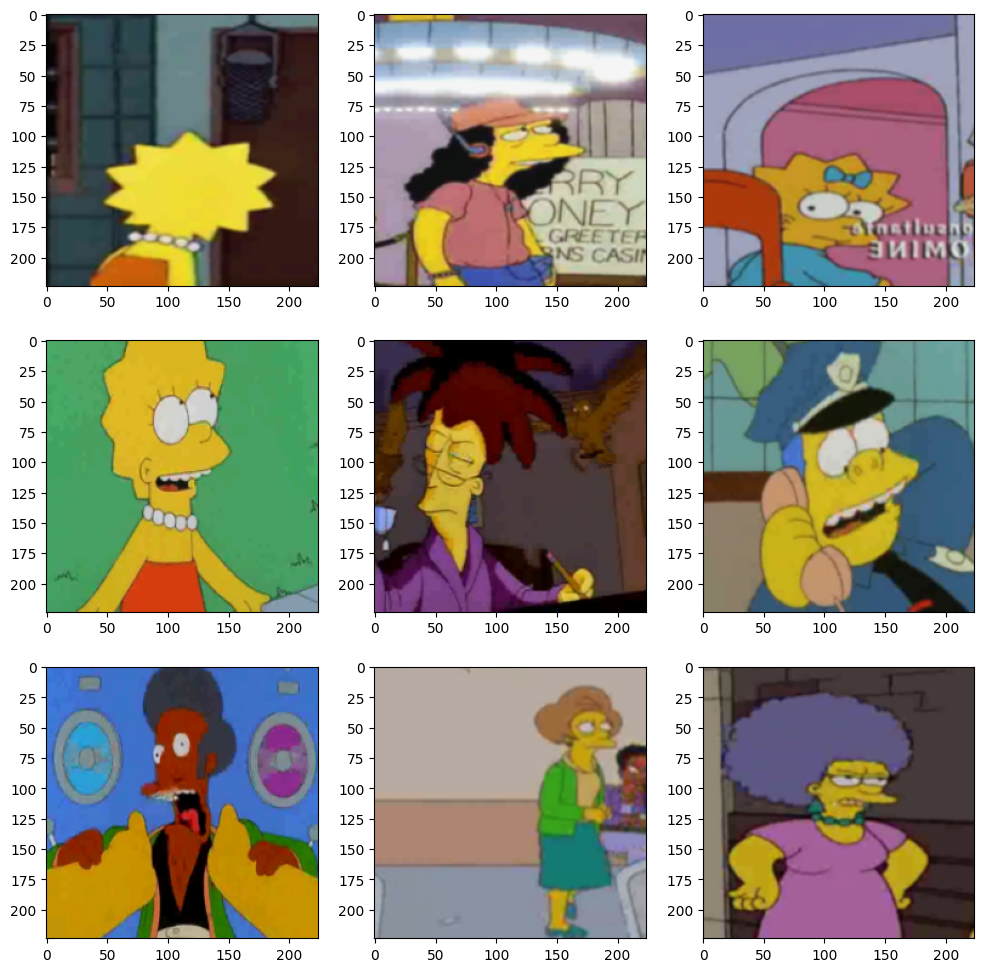

In [29]:
bx, by = next(iter(train_loader))

plt.figure(figsize=(12,12))
for i in range(9):
    plt.subplot(3,3,i+1)
    imshow(bx[i].cpu())
plt.show()


Шаг 3. Построение нейросети

In [30]:
import torchvision.models as models
from torchvision.models import ResNet18_Weights
import torch.nn as nn


Оптимизиурем - перенесем каналы в конец тензора, скомпилируем модель для получения cuda графа

In [67]:
def create_resnet18_simpsons(num_classes, device):

    model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    model = model.to(device)
    model = model.to(memory_format=torch.channels_last)

    try:
        model = torch.compile(model)
    except Exception as e:
        print("не сработало")

    return model


In [68]:
num_classes = len(label_encoder.classes_)
model_resnet18 = create_resnet18_simpsons(num_classes=num_classes, device=DEVICE)

print("Device:", next(model_resnet18.parameters()).device)


Device: cuda:0


In [69]:
criterion_resnet = nn.CrossEntropyLoss()

optimizer_resnet = torch.optim.AdamW(
    model_resnet18.parameters(),
    lr=3e-4,
    weight_decay=1e-2
)




In [70]:
torchsummary.summary(model_resnet18, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

Шаг 4. Функции для работы с моделью

In [39]:
from sklearn.metrics import f1_score

In [71]:
from tqdm import tqdm
import torch
import numpy as np

def train_one_epoch(model, train_loader, device, optimizer, loss_func):
    model.train()
    running_loss = 0.0

    all_preds = []
    all_labels = []

    for bx, by in tqdm(train_loader, desc="Train", ncols=90):
        bx, by = bx.to(device), by.to(device)

        optimizer.zero_grad()

        out = model(bx)
        loss = loss_func(out, by)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * bx.size(0)

        preds = out.argmax(dim=1)

        all_preds.append(preds.detach().cpu())
        all_labels.append(by.detach().cpu())


    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    epoch_loss = running_loss / len(train_loader.dataset)

    return epoch_loss, all_preds, all_labels


In [72]:
def validate_one_epoch(model, val_loader, device, loss_func):
    model.eval()

    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for bx, by in tqdm(val_loader, desc="Valid", ncols=90):
            bx, by = bx.to(device), by.to(device)

            out = model(bx)
            loss = loss_func(out, by)

            running_loss += loss.item() * bx.size(0)

            preds = out.argmax(dim=1)

            all_preds.append(preds.detach().cpu())
            all_labels.append(by.detach().cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    epoch_loss = running_loss / len(val_loader.dataset)

    return epoch_loss, all_preds, all_labels


In [73]:
import os
import torch
import datetime

def save_checkpoint(model, optimizer=None, epoch=None, f1=None, loss=None,
                    save_dir="/content/drive/MyDrive/Deep Learning school MIPT part 1",
                    filename="best_model.pt"):

    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, filename)

    checkpoint = {
        "model_state_dict": model.state_dict(),
        "epoch": epoch,
        "f1": f1,
        "loss": loss,
        "timestamp": datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    }

    if optimizer is not None:
        checkpoint["optimizer_state_dict"] = optimizer.state_dict()

    torch.save(checkpoint, save_path)
    print(f"Checkpoint saved: {save_path}")

    return save_path


In [74]:
def save_last_checkpoint(model, optimizer, epoch, save_dir="/content/drive/MyDrive/Deep Learning school MIPT part 1"):
    filename = "last_checkpoint.pt"
    return save_checkpoint(model, optimizer, epoch, filename=filename)


In [75]:
from sklearn.metrics import f1_score

def fit(model, train_loader, val_loader, optimizer, loss_func, epochs, device,
        save_dir="/content/drive/MyDrive/Deep Learning school MIPT part 1"):

    best_f1 = 0.0

    for epoch in range(1, epochs + 1):
        print(f"\n Epoch {epoch}/{epochs}")

        train_loss, train_preds, train_labels = train_one_epoch(
            model, train_loader, device, optimizer, loss_func
        )
        train_f1 = f1_score(train_labels, train_preds, average="micro")
        train_acc = (np.array(train_preds) == np.array(train_labels)).mean()


        val_loss, val_preds, val_labels = validate_one_epoch(
            model, val_loader, device, loss_func
        )
        val_f1 = f1_score(val_labels, val_preds, average="micro")

        print(f"Train loss: {train_loss:.4f} | Train F1: {train_f1:.4f}")
        print(f"Valid loss: {val_loss:.4f} | Valid F1: {val_f1:.4f}")

        val_acc = (np.array(val_preds) == np.array(val_labels)).mean()


        # Сохраняем последний чекпоинт
        save_last_checkpoint(model, optimizer, epoch, save_dir)

        if val_f1 > best_f1:
            best_f1 = val_f1
            save_checkpoint(
                model, optimizer, epoch,
                f1=val_f1, loss=val_loss,
                save_dir=save_dir,
                filename="best_model.pt"
            )
            print("new best model saved")

    print(f"\nbest F1/micro: {best_f1:.4f}")
    return best_f1


Модель переобучилась бы на 10 эпохах, так что для финального предсказания беру лучшую модель по ф1 скору на валидации.

In [78]:
best_f1 = fit(
    model=model_resnet18,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_resnet,
    loss_func=criterion_resnet,
    epochs=10,
    device=DEVICE,
    save_dir="/content/drive/MyDrive/Deep Learning school MIPT part 1"
)

print("\ntraining finished")
print("Best F1:", best_f1)



 Epoch 1/10


Valid: 100%|██████████████████████████████████████████████| 41/41 [00:39<00:00,  1.03it/s]


Train loss: 0.5512 | Train F1: 0.8790
Valid loss: 0.4112 | Valid F1: 0.9077
Checkpoint saved: /content/drive/MyDrive/Deep Learning school MIPT part 1/last_checkpoint.pt
Checkpoint saved: /content/drive/MyDrive/Deep Learning school MIPT part 1/best_model.pt
new best model saved

 Epoch 2/10


Valid: 100%|██████████████████████████████████████████████| 41/41 [00:29<00:00,  1.37it/s]


Train loss: 0.1067 | Train F1: 0.9784
Valid loss: 0.3093 | Valid F1: 0.9217
Checkpoint saved: /content/drive/MyDrive/Deep Learning school MIPT part 1/last_checkpoint.pt
Checkpoint saved: /content/drive/MyDrive/Deep Learning school MIPT part 1/best_model.pt
new best model saved

 Epoch 3/10


Valid: 100%|██████████████████████████████████████████████| 41/41 [00:29<00:00,  1.38it/s]


Train loss: 0.0712 | Train F1: 0.9842
Valid loss: 0.2348 | Valid F1: 0.9404
Checkpoint saved: /content/drive/MyDrive/Deep Learning school MIPT part 1/last_checkpoint.pt
Checkpoint saved: /content/drive/MyDrive/Deep Learning school MIPT part 1/best_model.pt
new best model saved

 Epoch 4/10


Valid: 100%|██████████████████████████████████████████████| 41/41 [00:28<00:00,  1.43it/s]


Train loss: 0.0552 | Train F1: 0.9877
Valid loss: 0.2926 | Valid F1: 0.9255
Checkpoint saved: /content/drive/MyDrive/Deep Learning school MIPT part 1/last_checkpoint.pt

 Epoch 5/10


Valid: 100%|██████████████████████████████████████████████| 41/41 [00:28<00:00,  1.42it/s]


Train loss: 0.0495 | Train F1: 0.9885
Valid loss: 0.2165 | Valid F1: 0.9448
Checkpoint saved: /content/drive/MyDrive/Deep Learning school MIPT part 1/last_checkpoint.pt
Checkpoint saved: /content/drive/MyDrive/Deep Learning school MIPT part 1/best_model.pt
new best model saved

 Epoch 6/10


Valid: 100%|██████████████████████████████████████████████| 41/41 [00:29<00:00,  1.38it/s]


Train loss: 0.0309 | Train F1: 0.9927
Valid loss: 0.1951 | Valid F1: 0.9566
Checkpoint saved: /content/drive/MyDrive/Deep Learning school MIPT part 1/last_checkpoint.pt
Checkpoint saved: /content/drive/MyDrive/Deep Learning school MIPT part 1/best_model.pt
new best model saved

 Epoch 7/10


Valid: 100%|██████████████████████████████████████████████| 41/41 [00:29<00:00,  1.38it/s]


Train loss: 0.0257 | Train F1: 0.9941
Valid loss: 0.2516 | Valid F1: 0.9413
Checkpoint saved: /content/drive/MyDrive/Deep Learning school MIPT part 1/last_checkpoint.pt

 Epoch 8/10


Valid: 100%|██████████████████████████████████████████████| 41/41 [00:29<00:00,  1.39it/s]


Train loss: 0.0301 | Train F1: 0.9924
Valid loss: 0.2051 | Valid F1: 0.9524
Checkpoint saved: /content/drive/MyDrive/Deep Learning school MIPT part 1/last_checkpoint.pt

 Epoch 9/10


Valid: 100%|██████████████████████████████████████████████| 41/41 [00:29<00:00,  1.37it/s]


Train loss: 0.0401 | Train F1: 0.9897
Valid loss: 0.2471 | Valid F1: 0.9413
Checkpoint saved: /content/drive/MyDrive/Deep Learning school MIPT part 1/last_checkpoint.pt

 Epoch 10/10


Valid: 100%|██████████████████████████████████████████████| 41/41 [00:31<00:00,  1.32it/s]


Train loss: 0.0296 | Train F1: 0.9925
Valid loss: 0.2229 | Valid F1: 0.9467
Checkpoint saved: /content/drive/MyDrive/Deep Learning school MIPT part 1/last_checkpoint.pt

best F1/micro: 0.9566

training finished
Best F1: 0.9566297286969813


In [80]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

@torch.no_grad()
def show_images2(n_rows, n_cols, dataset, model):
    model.eval()

    fig, axs = plt.subplots(
        nrows=n_rows,
        ncols=n_cols,
        figsize=(n_cols * 4, n_rows * 4),
        sharey=True,
        sharex=True
    )

    for fig_x in axs.flatten():
        idx = np.random.randint(0, len(dataset))
        im_val, label = dataset[idx]

        actual_label = " ".join(
            word.capitalize() for word in
            label_encoder.inverse_transform([label])[0].split("_")
        )

        imshow(im_val.cpu(), title=actual_label, plt_ax=fig_x)

        logits = model(im_val.unsqueeze(0).to(DEVICE))
        prob = nn.functional.softmax(logits, dim=-1).cpu().numpy()[0]

        pred_idx = prob.argmax()
        pred_label = " ".join(
            w.capitalize() for w in
            label_encoder.inverse_transform([pred_idx])[0].split("_")
        )
        pred_proba = prob[pred_idx] * 100
        fig_x.add_patch(
            patches.Rectangle((0, 190), 150, 30, color='white')
        )
        fig_x.text(
            2, 195,
            f"{pred_label}: {pred_proba:.1f}%",
            horizontalalignment='left',
            fontsize=8,
            color='black',
            fontweight='bold'
        )

        fig_x.set_axis_off()

    return None


In [82]:
best_model = create_resnet18_simpsons(num_classes, device=DEVICE)
checkpoint = torch.load("/content/drive/MyDrive/Deep Learning school MIPT part 1/best_model.pt")
best_model.load_state_dict(checkpoint["model_state_dict"])
best_model.eval()


OptimizedModule(
  (_orig_mod): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

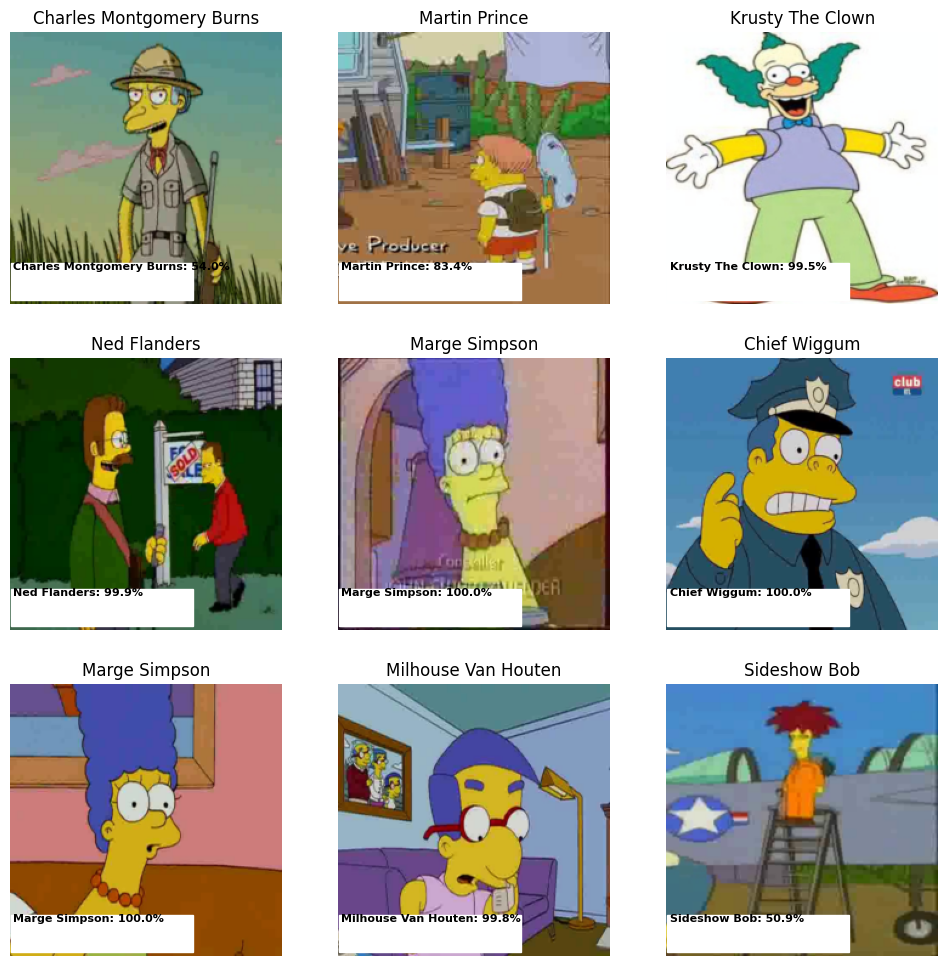

In [83]:
show_images2(n_rows = 3, n_cols = 3, dataset = val_dataset, model = best_model)

In [84]:
test_dataset = SimpsonsDataset(test_files, label_encoder = label_encoder, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)

In [85]:
def predict(model, loader):
    model.eval()
    all_predictions = torch.tensor([]).to(DEVICE).int()
    print("Test mode...")
    for inputs in tqdm_notebook(loader):
        inputs = inputs.to(DEVICE)

        with torch.no_grad():
            outputs = model(inputs)

            predictions = outputs.argmax(-1).int()
            all_predictions = torch.cat((all_predictions, predictions), 0)
    return all_predictions.cpu()

In [87]:
predicted_numeric_labels = predict(best_model, test_loader)

Test mode...


  0%|          | 0/16 [00:00<?, ?it/s]

In [88]:
predicted_text_labels = label_encoder.inverse_transform(predicted_numeric_labels)

In [89]:
import pandas as pd
sample_submission = pd.read_csv("/content/sample_submission.csv")
sample_submission.head(10)

,Id,Expected
0,img0.jpg,bart_simpson
1,img1.jpg,bart_simpson
2,img2.jpg,bart_simpson
3,img3.jpg,bart_simpson
4,img4.jpg,bart_simpson
5,img5.jpg,bart_simpson
6,img6.jpg,bart_simpson
7,img7.jpg,bart_simpson
8,img8.jpg,bart_simpson
9,img9.jpg,bart_simpson


In [90]:
my_submission = pd.DataFrame({'Id': [path.name for path in test_files], 'Expected': predicted_text_labels})
my_submission.head(10)

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
5,img102.jpg,kent_brockman
6,img103.jpg,edna_krabappel
7,img104.jpg,chief_wiggum
8,img105.jpg,lisa_simpson
9,img106.jpg,kent_brockman


In [92]:
my_submission.to_csv('best_model_predictions.csv', index=False)

сабмит на каггл

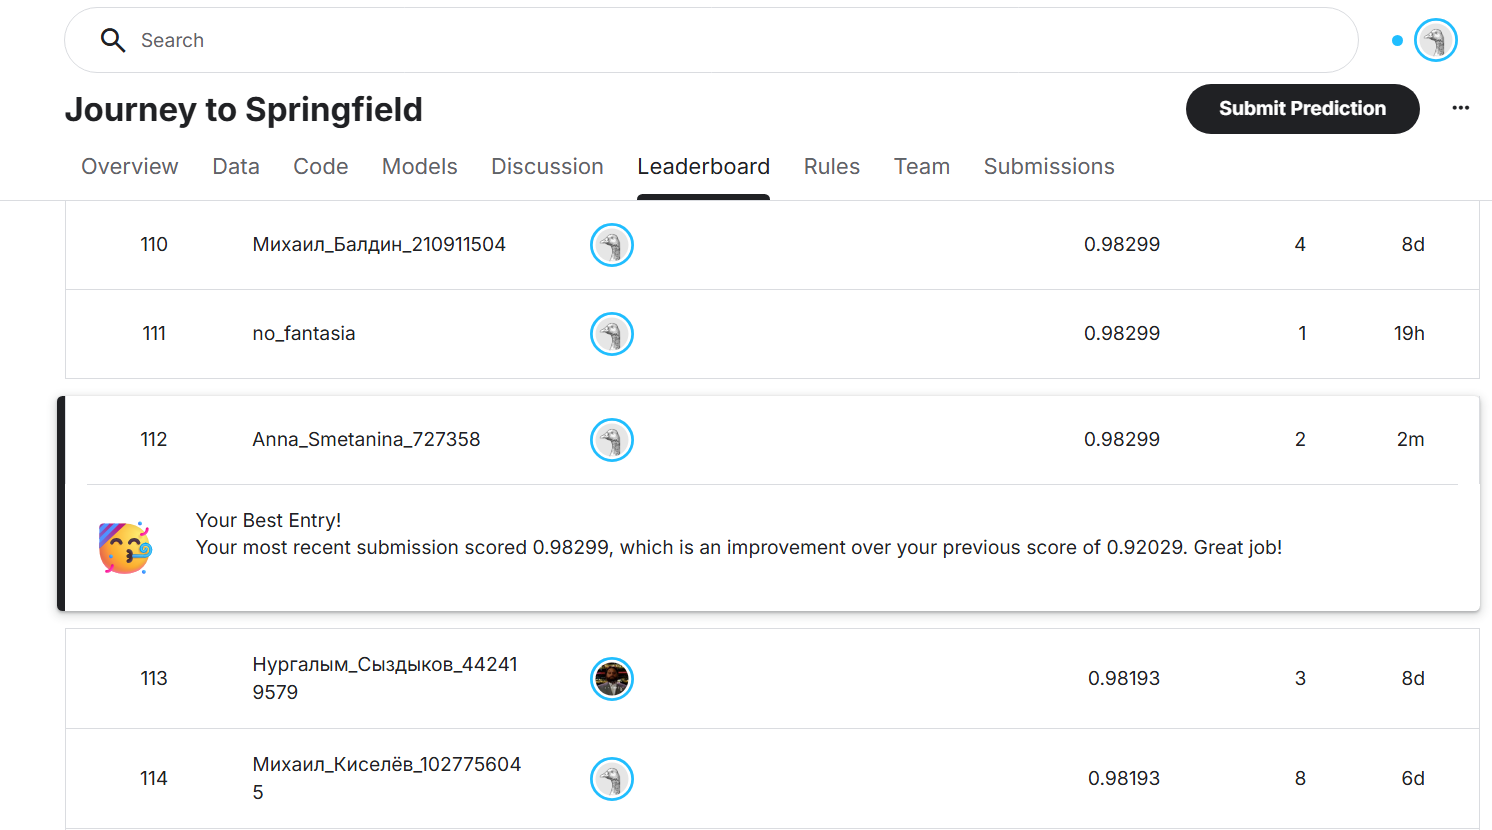